In [1]:
import datetime as dt

from IPython.display import Image

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from scipy.stats import randint as sp_randint

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with statistically assigned labels)

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

In [3]:
ranges_m = [0.3, 0.7]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m['RMonetary']

0.3      7.145611
0.7    127.860000
Name: RMonetary, dtype: float64

In [4]:
ranges_d = [0.3, 0.7]
quantiles_d = customer_profile.quantile(q=ranges_d)
quantiles_d['Delta']

0.3      1.0
0.7    224.0
Name: Delta, dtype: float64

In [5]:
ranges_r = [0.3, 0.8]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r['Recency']

0.3     22.0
0.8    179.0
Name: Recency, dtype: float64

In [6]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreD(x, data, thresh):
    if x <= thresh[data][ranges_d[0]]:
        return 1
    elif x <= thresh[data][ranges_d[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [7]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreM, args=('RMonetary', quantiles_m))
customer_profile['DScore'] = customer_profile['Delta'].apply(ScoreD, args=('Delta', quantiles_d))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.3 * customer_profile['MScore']
                           + 0.4 * customer_profile['DScore']
                           + 0.3 * customer_profile['RScore'])
#customer_profile.describe()

In [8]:
ranges = [0.2, 0.7]
quantiles = customer_profile.quantile(q=ranges)
#quantiles

In [9]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [10]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label == 'Medium']
df_minority = customer_labeled[customer_labeled.Label == 'High']
df_middle   = customer_labeled[customer_labeled.Label == 'Low']

customer_labeled.Label.value_counts()

Medium    2110
High      1231
Low        981
Name: Label, dtype: int64

In [11]:
'''customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)
customer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)'''

"customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)\ncustomer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)"

In [12]:
'''fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],
           c=customer_labeled['Label_num'])
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()'''

"fig = plt.figure()\nax = Axes3D(fig)\nax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],\n           c=customer_labeled['Label_num'])\nax.set_xlabel('Delta')\nax.set_ylabel('Recency')\nax.set_zlabel('Relative Monetary')\nplt.show()"

In [13]:
# Upsample minority classes

df_minority_upsampled = resample(df_minority,
                                 replace=True, # sample with replacement
                                 n_samples=len(df_majority))

df_middle_upsampled = resample(df_middle,
                               replace=True,
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_labeled = df_upsampled
df_upsampled.Label.value_counts()

Low       2110
Medium    2110
High      2110
Name: Label, dtype: int64

In [14]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize

def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [15]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore
customer_labeled = customer_labeled[['Recency', 'RFrequency', 'Max_items', 'Label_num']]

label = customer_labeled.pop('Label_num')

scaler = MinMaxScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_labeled, label, stratify=label, test_size=0.3)

In [16]:
train_label.head()

2063    2
370     2
974     2
3656    1
356     2
Name: Label_num, dtype: int64

## Expected prediction

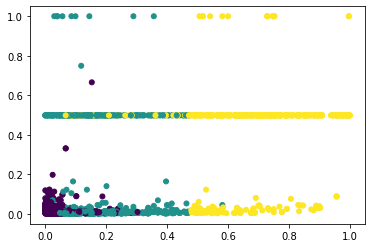

In [17]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)

## Decision Tree

In [18]:
# Decision tree

param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "criterion": ["entropy", "gini"],
              "splitter": ["best", "random"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()
grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=50, n_jobs=10,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x116c28a30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x116fcbfd0>,
                                        'splitter': ['best', 'random']},
                   scoring=make_scorer(accuracy_score))

In [19]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 29, 'min_samples_split': 43, 'splitter': 'random'}
Mean and std of this setting  0.8641358371867532 0.02896186050180595


In [20]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=5,
                                  min_samples_split=23, min_samples_leaf=48)

dec_t = dec_t.fit(train_set, train_label)

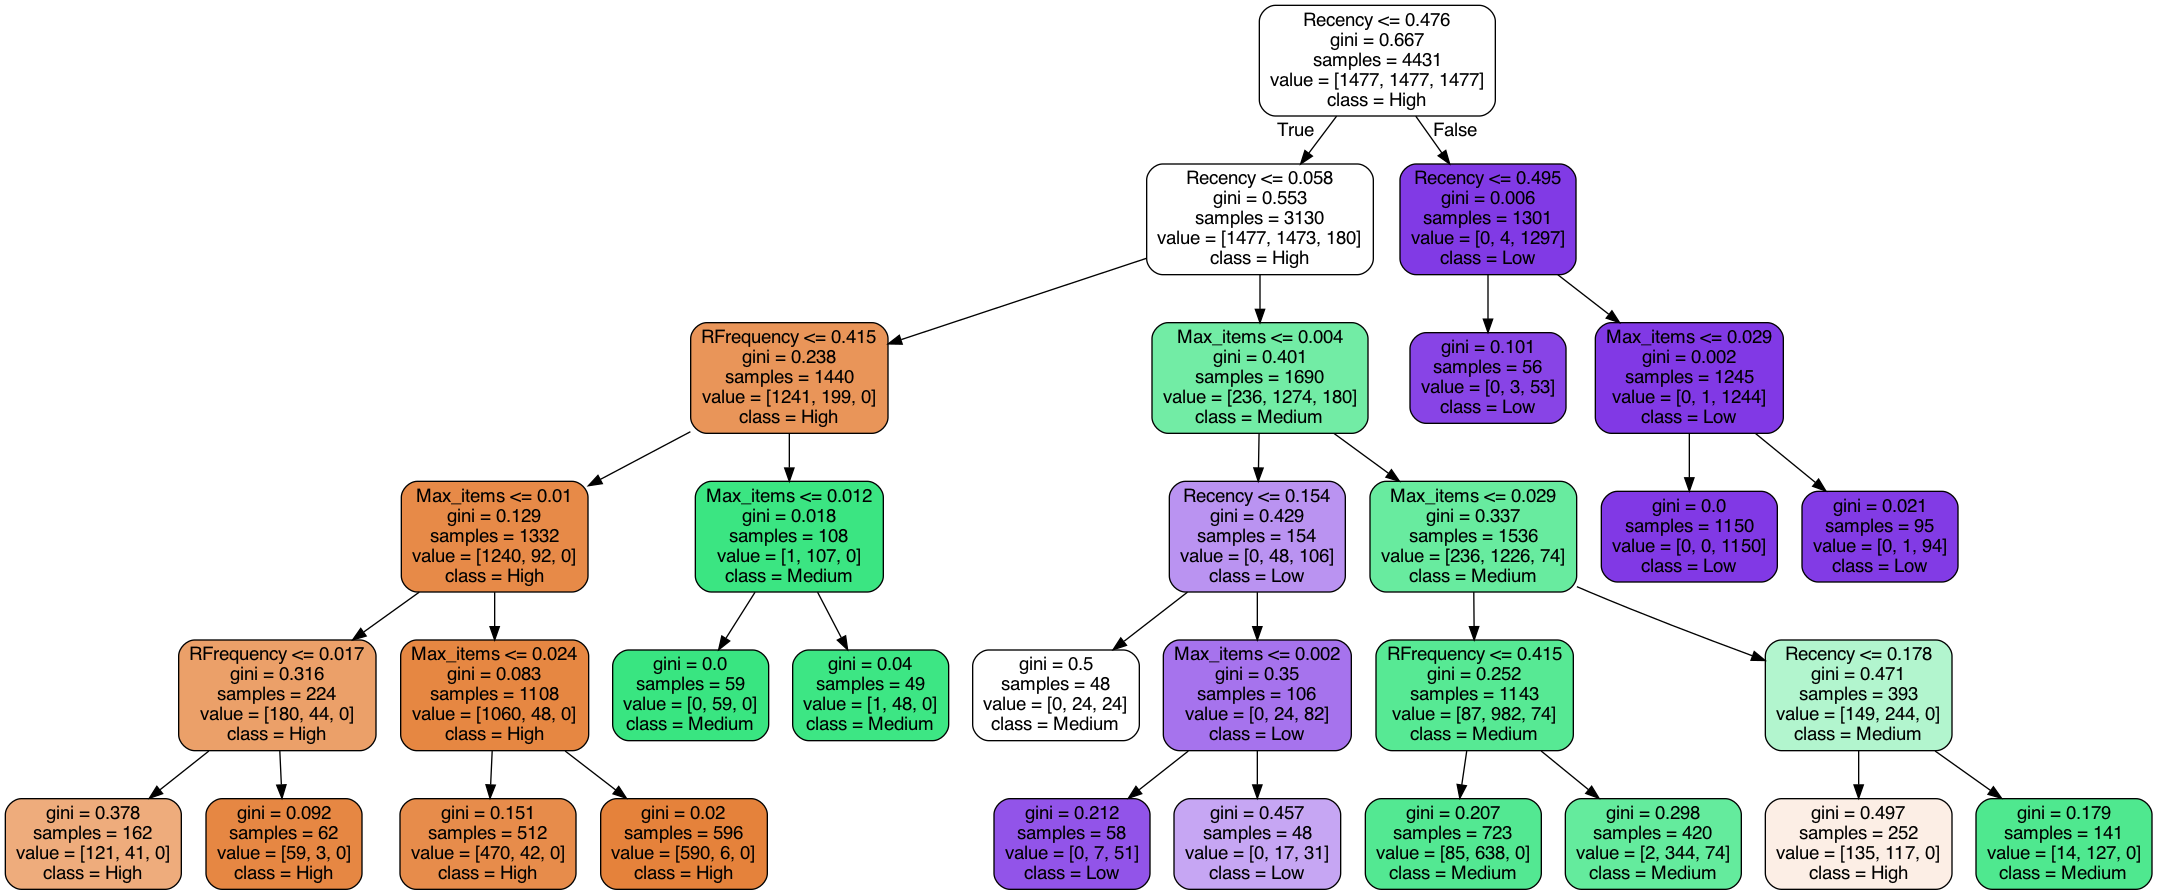

In [21]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'RFrequency', 'Max_items'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [22]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [23]:
train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [24]:
from sklearn.metrics import classification_report

def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [25]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9013766644098398
Accuracy test set:  0.885202738283307

F1 score train set: 0.901632815144722
F1 score test set:  0.8850298161696937
Train:
              precision    recall  f1-score   support

        High       0.87      0.93      0.90      1477
      Medium       0.86      0.84      0.85      1477
         Low       0.98      0.93      0.96      1477

    accuracy                           0.90      4431
   macro avg       0.90      0.90      0.90      4431
weighted avg       0.90      0.90      0.90      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.85      0.93      0.88       633
      Medium       0.85      0.80      0.82       633
         Low       0.97      0.93      0.95       633

    accuracy                           0.89      1899
   macro avg       0.89      0.89      0.89      1899
weighted avg       0.89      0.89      0.89      1899



In [26]:
# compute confusion matrix

from sklearn.metrics import confusion_matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1375  102    0]
 [ 209 1240   28]
 [   0   98 1379]]
------------------
Test:
[[587  46   0]
 [107 506  20]
 [  0  45 588]]


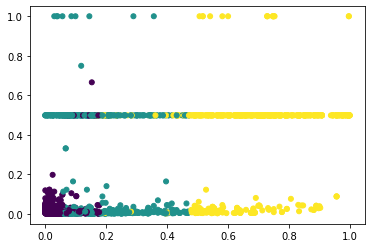

In [27]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)

## SVM

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm =  SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

svm_binarize = OneVsRestClassifier(SVC(kernel='poly', C=0.5, gamma='scale'))
svm_binarize.fit(train_set, train_label_binarized)

OneVsRestClassifier(estimator=SVC(C=0.5, kernel='poly'))

In [29]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)

train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [30]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8004965019183029
Accuracy test set:  0.8030542390731964

F1 score train set: 0.790170702289878
F1 score test set:  0.7939822916524226
Train:
              precision    recall  f1-score   support

        High       0.70      0.99      0.82      1477
      Medium       0.82      0.52      0.64      1477
         Low       0.94      0.89      0.92      1477

    accuracy                           0.80      4431
   macro avg       0.82      0.80      0.79      4431
weighted avg       0.82      0.80      0.79      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.70      0.98      0.82       633
      Medium       0.82      0.53      0.64       633
         Low       0.95      0.90      0.92       633

    accuracy                           0.80      1899
   macro avg       0.82      0.80      0.79      1899
weighted avg       0.82      0.80      0.79      1899



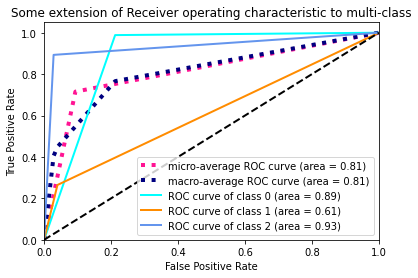

In [31]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

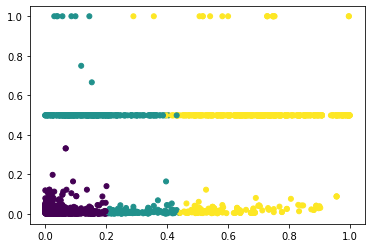

In [32]:
# x: Frequency
# y: Max items
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_svm, s=25)

## KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [34]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [35]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9390656736628301
Accuracy test set:  0.909952606635071

F1 score train set: 0.938666962632023
F1 score test set:  0.9088805900217208
Train:
              precision    recall  f1-score   support

        High       0.89      0.99      0.93      1477
      Medium       0.95      0.86      0.90      1477
         Low       0.99      0.97      0.98      1477

    accuracy                           0.94      4431
   macro avg       0.94      0.94      0.94      4431
weighted avg       0.94      0.94      0.94      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.85      0.97      0.90       633
      Medium       0.92      0.79      0.85       633
         Low       0.97      0.97      0.97       633

    accuracy                           0.91      1899
   macro avg       0.91      0.91      0.91      1899
weighted avg       0.91      0.91      0.91      1899



## Classification with Random Forest

In [36]:
# To find the best set of parameter setting, we can run a grid search.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1,len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2:0.25}]}

n_iter_search = 50

clf = RandomForestClassifier(n_estimators=30)

grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.25, 1: 0.5,
                                                          2: 0.25}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1177af250>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1199e5a90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x117795eb0>},
     

In [37]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'class_weight': {0: 0.25, 1: 0.5, 2: 0.25}, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 46, 'min_samples_split': 12}
Mean and std of this setting  0.9020529799639132 0.006982023807818262


In [38]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             class_weight= 'balanced',
                             max_depth=2, 
                             min_samples_split=12,
                             min_samples_leaf=41,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

In [39]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [40]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8842247799593771
Accuracy test set:  0.8720379146919431

F1 score train set: 0.8866668486320594
F1 score test set:  0.8748441240135681
Train:
              precision    recall  f1-score   support

        High       0.93      0.84      0.88      1477
      Medium       0.77      0.94      0.84      1477
         Low       1.00      0.88      0.93      1477

    accuracy                           0.88      4431
   macro avg       0.90      0.88      0.89      4431
weighted avg       0.90      0.88      0.89      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.93      0.81      0.86       633
      Medium       0.75      0.94      0.83       633
         Low       1.00      0.88      0.93       633

    accuracy                           0.87      1899
   macro avg       0.89      0.87      0.87      1899
weighted avg       0.89      0.87      0.87      1899



## Neural networks

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_labeled[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [43]:
history = model.fit(train_set, train_label_nn,
                    epochs=40,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/40
13/13 [==============================] - 0s 24ms/step - loss: 1.0976 - accuracy: 0.4221 - val_loss: 1.0760 - val_accuracy: 0.5474
Epoch 2/40
13/13 [==============================] - 0s 10ms/step - loss: 1.0663 - accuracy: 0.5753 - val_loss: 1.0389 - val_accuracy: 0.7263
Epoch 3/40
13/13 [==============================] - 0s 8ms/step - loss: 1.0221 - accuracy: 0.6949 - val_loss: 0.9825 - val_accuracy: 0.7444
Epoch 4/40
13/13 [==============================] - 0s 25ms/step - loss: 0.9571 - accuracy: 0.7053 - val_loss: 0.8898 - val_accuracy: 0.7150
Epoch 5/40
13/13 [==============================] - 0s 10ms/step - loss: 0.8675 - accuracy: 0.6930 - val_loss: 0.7714 - val_accuracy: 0.7120
Epoch 6/40
13/13 [==============================] - 0s 13ms/step - loss: 0.7620 - accuracy: 0.7065 - val_loss: 0.6622 - val_accuracy: 0.7098
Epoch 7/40
13/13 [==============================] - 0s 7ms/step - loss: 0.6646 - accuracy: 0.7220 - val_loss: 0.5698 - val_accuracy: 0.7684
Epoch 8/40
13/1

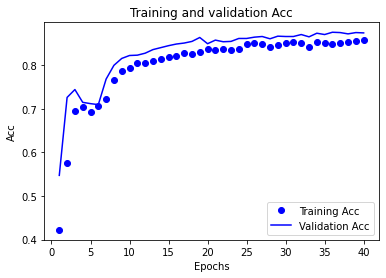

In [44]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [45]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [46]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8706838185511171
Accuracy test set:  0.8583464981569247

F1 score train set: 0.8713036208891021
F1 score test set:  0.8591803733443554
Train:
              precision    recall  f1-score   support

        High       0.87      0.90      0.89      1477
      Medium       0.80      0.82      0.81      1477
         Low       0.95      0.89      0.92      1477

    accuracy                           0.87      4431
   macro avg       0.87      0.87      0.87      4431
weighted avg       0.87      0.87      0.87      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.84      0.89      0.86       633
      Medium       0.79      0.79      0.79       633
         Low       0.96      0.89      0.93       633

    accuracy                           0.86      1899
   macro avg       0.86      0.86      0.86      1899
weighted avg       0.86      0.86      0.86      1899



## Classification with Naive Bayes

In [47]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [48]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8280297901150981
Accuracy test set:  0.8220115850447604

F1 score train set: 0.823084393971886
F1 score test set:  0.8175040472416997
Train:
              precision    recall  f1-score   support

        High       0.77      0.95      0.85      1477
      Medium       0.81      0.63      0.71      1477
         Low       0.91      0.90      0.91      1477

    accuracy                           0.83      4431
   macro avg       0.83      0.83      0.82      4431
weighted avg       0.83      0.83      0.82      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.75      0.94      0.83       633
      Medium       0.80      0.62      0.70       633
         Low       0.93      0.91      0.92       633

    accuracy                           0.82      1899
   macro avg       0.83      0.82      0.82      1899
weighted avg       0.83      0.82      0.82      1899



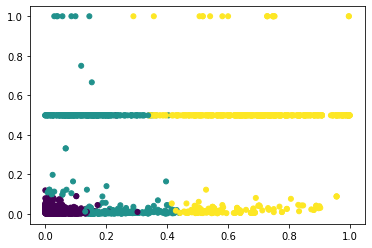

In [49]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_gnb, s=25)